<a href="https://colab.research.google.com/github/nikhils10/Movie-Recommendation-Engine/blob/main/Movie_Recommender_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Installing Packages
!pip install wordcloud
!pip install -U spacy
!python -m spacy download en_core_web_lg

In [ ]:
## Importing Packages 
import pandas as pd
import nltk
# nltk.download('all')
# nltk.download('punkt')
import json
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import nltk
import spacy
# import en_core_web_lg
from keras.layers import TextVectorization 
import string
# from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
import string
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize


In [42]:
##Matplotlib Parameters
import matplotlib.ticker as ticker
from pylab import rcParams
rcParams['figure.figsize'] = 6,6
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
plt.style.context('fivethirtyeight')

In [ ]:
## Reading csv files
## path /content/drive/MyDrive/Datasets/movie_lens/
metadata = pd.read_csv('/content/drive/MyDrive/Datasets/movie_lens/movies_metadata.csv')
links_small = pd.read_csv('/content/drive/MyDrive/Datasets/movie_lens/links_small.csv')
ratings_small = pd.read_csv('/content/drive/MyDrive/Datasets/movie_lens/ratings_small.csv')
credits = pd.read_csv('/content/drive/MyDrive/Datasets/movie_lens/credits.csv')
keywords = pd.read_csv('/content/drive/MyDrive/Datasets/movie_lens/keywords.csv')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# About the Data 

This dataset consists of the following files:

**movies_metadata.csv**: The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

**keywords.csv**: Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.

**credits.csv**: Consists of Cast and Crew Information for all our movies. Available in the form of a stringified JSON Object.

**links.csv**: The file that contains the TMDB and IMDB IDs of all the movies featured in the Full MovieLens dataset.

**links_small.csv**: Contains the TMDB and IMDB IDs of a small subset of 9,000 movies of the Full Dataset.

**ratings_small.csv**: The subset of 100,000 ratings from 700 users on 9,000 movies.

# Exploratory Data Analysis

In [ ]:
revenue = metadata[["title","revenue"]].dropna()

revenue['revenue'] = revenue['revenue'].apply(lambda x:float(x)/(1000**3))

revenue = revenue.sort_values(by="revenue",ascending=False)
ax = sns.barplot(x = revenue['revenue'][:15], y=revenue['title'][:15], data=revenue)
plt.title("Movies with Most Revenue", weight="bold")
plt.xlabel("Revenue IN Billion $", weight="bold")
plt.ylabel("Movie Titles", weight="bold")
plt.show()

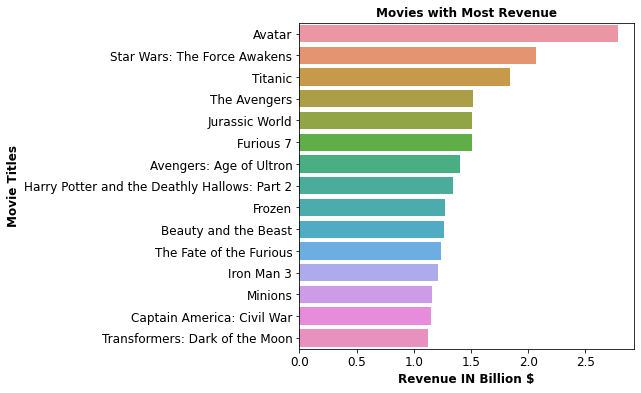

In [ ]:
revenue['revenue'] = revenue['revenue'].apply(lambda x:float(x)/(1000**3))

revenue = revenue.sort_values(by="revenue",ascending=False)
ax = sns.barplot(x = revenue['revenue'][:15], y=revenue['title'][:15], data=revenue)
plt.title("Movies with Most Revenue", weight="bold")
plt.xlabel("Revenue IN Billion $", weight="bold")
plt.ylabel("Movie Titles", weight="bold")
plt.show()

> The bar graph displays the top movies with most revenue .

> Avatar is the movie that has most revenue followed by Star wars, Titanic and Avengers .

> Top 15 movies have a revenue more than 1 Billion Dollars.

> Revenue Difference between Avatar and Star Wars is maximum in comparision to subsequent movies ranked .

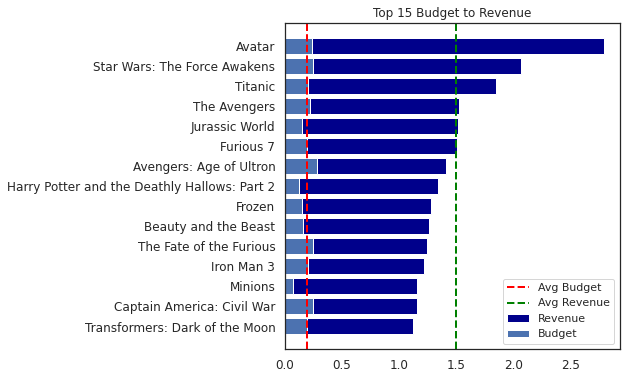

In [62]:
# Budget to Revenue Plot 
ax = plt.subplot()
df = metadata[["title","revenue","budget"]].dropna()
df['revenue'] = df['revenue'].apply(lambda x:float(x)/(1000**3))
df['budget'] = df['budget'].apply(lambda x:float(x)/(1000**3))
df = df.sort_values(by="revenue",ascending=False)
sub_df = df.head(15)
sub_df = sub_df.sort_values(by='revenue')
ax.barh(sub_df["title"], sub_df["revenue"],color='darkblue',label='Revenue')
ax.barh(sub_df["title"], sub_df["budget"],label='Budget')
ax.legend(bbox_to_anchor=(1.0, 1.0))
budget_mean = sub_df['budget'].mean()
revenue_mean = sub_df['revenue'].mean()
plt.title('Top 15 Budget to Revenue')
plt.axvline(budget_mean, color='red', linestyle='dashed', linewidth=2,label='Avg Budget')
plt.axvline(revenue_mean, color='green', linestyle='dashed', linewidth=2,label='Avg Revenue')
plt.legend()
plt.show()


From a simple plot we can gather a lot of inferences like :-
> The average budget is very close to what movies spend.

> Movies with high revenue don't necessarily mean that they have the highest budget . Argument to support this is Avatar and Avenger:Age of Ultron. 

> 

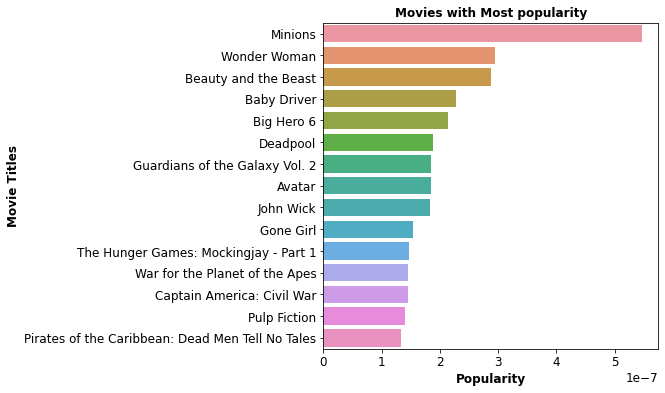

In [ ]:
## popularity as well
popularity = metadata[["title","popularity"]].dropna()
popularity['popularity'] = popularity['popularity'].apply(lambda x:float(x)/(1000**3))

popularity = popularity.sort_values(by="popularity",ascending=False)
ax = sns.barplot(x = popularity['popularity'][:15], y=popularity['title'][:15], data=popularity)
plt.title("Movies with Most popularity", weight="bold")
plt.xlabel("Popularity", weight="bold")
plt.ylabel("Movie Titles", weight="bold")
plt.show()

> Minions , Wonder Woman and Beauty and the Beast are most popular movies.

> The movie choice indicates that movies suitable for children are most popular 

### Exploring Long Tail Phenomenon in Recommendation

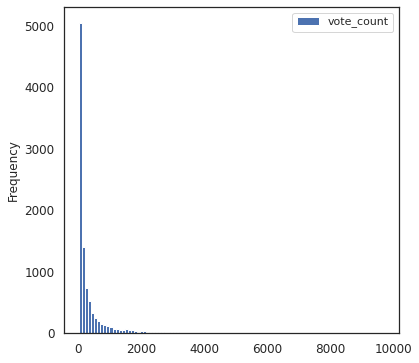

In [90]:
## Plot vote counts
long_tail = metadata.loc[metadata['vote_count']<10000,'vote_count']
long_tail = pd.DataFrame(long_tail)
long_tail.sort_values(by='vote_count',ascending=False,inplace=True)
long_tail.head(10000).plot(kind='hist',bins=100)

The long tail is a common phenomenon in recommendation based problems.
What happens is the recommendations are always surrounding popular choices and the more unique items miss out .
The threshold of algo should give items which are diverse and new .
But since many less users interact with them the performance of algo will be less accurate as its a sparse area.

# Content Based Recommendation 
Movies metadata contains many attributes which can be used to make a content based recommender system.

# Data Cleaning 

In [ ]:
## Using literal_eval to get data in suitable format for easier extraction of information
metadata['genres'] = metadata['genres'].apply(lambda x: ast.literal_eval(x) if(pd.notnull(x)) else x)
credits['crew'] = credits['crew'].apply(ast.literal_eval)

## Fetching Main Cast

Movie cast has order in which cast are ranked .
The main actor is given 0 and so on.
We take the top 3 actors from each movie .
Actors in movies can be very influencial and important feature for reason to watch a movie.

In [ ]:
## Function to fetch main cast from movie cast
def fetch_main_cast(a):
    list_ = []
    for i in a:
        if i['order'] <=2:
            list_.append(i['name'])
    return list_

## Fetching Director

Same way like actor , the director the movie is very important part of the movie. Some directors like Christopher Nolan has a huge fan base and such a feature needs to be captured .

In [ ]:
## Function to fetch director of the movie 
def fetch_dir(a):
    list_ = []
    for i in a:
        if i['job'] =='Director':
            list_.append(i['name'])
    return list_

## Fetching Genre

Genre of the movie is also a very important attribute of the movie.
Animation films are famous among children. A specific user might like a particular type of genre. 


In [ ]:
## Function to fetch genre of the movie 
## Multiple genre for each movie
def fetch_genre(a):
    list_ = []
    for i in a:
        list_.append(i['name'])
    return list_

In [ ]:
## Converting id's into int so the dataframes can be merged
def convert_into_int(x):
    try:
        x = int(x)
    except:
        x = 0
    return x


metadata['id'] = metadata['id'].apply(convert_into_int)
credits['id'] = credits['id'].astype('int',errors='ignore')

In [ ]:
## Merging different files for easier access 
merged = metadata.merge(credits,on='id')
merged.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45533,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,/jldsYflnId4tTWPx8es3uzsB1I8.jpg,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de..."
45534,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,/xZkmxsNm

In [ ]:
merged.merge(keywords,on='id')


In [ ]:
## Taking subset dataset to limit our movie size to 9000 movies instead of 1 million
## To reduce the computation time since we are resource limited 
subset = merged[merged['id'].isin(links_small['tmdbId'].values)]

In [ ]:
subset = subset.merge(keywords,on='id')

In [ ]:
## get director
subset['director'] = subset['crew'].apply(lambda x: fetch_dir(x))
## get genre 
subset['genres'] = subset['genres'].apply(lambda x: fetch_genre(x))
## get actor 
subset['cast'] = subset['cast'].apply(ast.literal_eval)
## only fetch main caste 
subset['main_cast'] = subset['cast'].apply(lambda x: fetch_main_cast(x))


In [ ]:
## extract keywords 
subset['keywords'] = subset['keywords'].apply(ast.literal_eval)

In [ ]:
## Extract keywords function
def extract_keywords(x):
    list_ = []
    for i in x:
        list_.append(i['name'])
    return list_

subset['keywords'] = subset['keywords'].apply(extract_keywords)

In [ ]:
## Make title as a list for easier string concatenation
def make_list(x):
    list_ = []
    list_.append(x)
    return list_
subset['title'] = subset['title'].apply(make_list)

In [ ]:
## Creating one feature for each movie 
subset['all'] = subset['director'] + subset['main_cast'] + subset['genres'] + subset['keywords'] + subset['title']

Combining all features like director , genre, actors, movie title, keywords and making one feature for each movie .
This string needs to be converted into embeddings

# Preprocessing Textual Data

### Lowercasing

In [ ]:
## Converting into lowercase
def lower_case(x):
    list_ = []
    for i in x:
        list_.append(i.lower())
    return list_

subset['clean_data'] = subset['all'].apply(lower_case)
subset['clean_data']

0       [john lasseter, tom hanks, tim allen, don rick...
1       [joe johnston, robin williams, jonathan hyde, ...
2       [howard deutch, walter matthau, jack lemmon, a...
3       [forest whitaker, whitney houston, angela bass...
4       [charles shyer, steve martin, diane keaton, ma...
                              ...                        
9214    [gregg champion, sidney poitier, wendy crewson...
9215    [tinu suresh desai, akshay kumar, ileana d'cru...
9216    [ashutosh gowariker, hrithik roshan, pooja heg...
9217    [hideaki anno, shinji higuchi, hiroki hasegawa...
9218    [ron howard, paul mccartney, ringo starr, john...
Name: clean_data, Length: 9219, dtype: object

### Remove Stopwords, Punctuations 

In [ ]:
## Remove stopwords

##Remove punctuation from the words after stopwords
punctuation_set = set(string.punctuation)

##stopwords -we fetch a list of stopwords
stop_words_set = set(stopwords.words('english'))

##stopwords removal
def remove_stopwords(sentence):
  filtered_words = []
  for word in sentence:
    if word not in stop_words_set:
      filtered_words.append(word) 
  
  return filtered_words

##punctuation removal
def remove_punctuations(sentence):
  filtered_words = []
  for word in sentence:
    if word not in punctuation_set:
      filtered_words.append(word) 
  
  return filtered_words

In [ ]:
subset['clean_data'] = subset['clean_data'].apply(remove_punctuations)
subset['clean_data'] = subset['clean_data'].apply(remove_stopwords)

In [ ]:
subset['clean_data']

0       [john lasseter, tom hanks, tim allen, don rick...
1       [joe johnston, robin williams, jonathan hyde, ...
2       [howard deutch, walter matthau, jack lemmon, a...
3       [forest whitaker, whitney houston, angela bass...
4       [charles shyer, steve martin, diane keaton, ma...
                              ...                        
9214    [gregg champion, sidney poitier, wendy crewson...
9215    [tinu suresh desai, akshay kumar, ileana d'cru...
9216    [ashutosh gowariker, hrithik roshan, pooja heg...
9217    [hideaki anno, shinji higuchi, hiroki hasegawa...
9218    [ron howard, paul mccartney, ringo starr, john...
Name: clean_data, Length: 9219, dtype: object

### Lemmmatization

In [ ]:
## Reducing our vocab size by using Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(x):
    return [wordnet_lemmatizer.lemmatize(w) for w in x]

subset['clean_data'] = subset['clean_data'].apply(lemmatize)

In [ ]:
subset['data'] = subset['clean_data'].apply(lambda x:''.join(x))

### Pre-trained Word Embeddings 300 Dimensions 

In [ ]:
## Pre-trained word embeddings from Spacy 
## Converting our feature into embeddings of 300 dimension vectors 
from keras.layers import TextVectorization 
import spacy
import en_core_web_lg
nlp = spacy.load("en_core_web_lg")
Vectorizer = TextVectorization()


In [ ]:
## Function to apply embeddings 
def get_vector(x):
    doc = nlp(x)
    return doc.vector

In [ ]:
## word2vec
wordvec_arrays = np.zeros((len(subset['data']), 300)) 

for i in range(len(subset['data'])):
    wordvec_arrays[i,:] = get_vector(subset['data'][i]).reshape(1,300)
    wordvec_df = pd.DataFrame(wordvec_arrays)

In [ ]:
## Showing vectors for each movie
wordvec_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.000954,0.100750,-0.006991,-0.016906,0.045532,-0.047784,-0.031496,-0.053476,0.048904,0.918508,-0.132134,-0.055953,0.027882,0.027096,-0.081941,-0.050431,-0.010694,0.395730,-0.008153,-0.056990,0.024398,-0.005019,0.064891,-0.022226,0.040587,0.013261,-0.085921,0.025233,-0.104212,0.044534,-0.069426,0.042112,-0.032795,0.052056,0.081049,0.026318,0.048733,0.012552,-0.066616,-0.049951,...,0.093021,-0.018875,-0.028181,0.025687,0.106740,-0.144616,0.009376,0.048422,0.071899,0.031951,0.032010,-0.002074,-0.013751,-0.026078,-0.039018,-0.037216,0.037382,0.024481,0.054129,0.048989,0.058933,0.030908,-0.072567,-0.020232,0.021652,0.020977,0.009078,0.000128,-0.063914,-0.026712,-0.073613,0.009864,-0.011630,0.000488,-0.002350,-0.043521,-0.059645,-0.007625,-0.066261,0.048591
1,-0.053584,0.069413,-0.033931,0.036123,-0.009213,0.001520,0.023727,-0.065536,-0.006149,0.727659,-0.154194,-0.075531,-0.056979,0.012899,-0.026702,0.005630,-0.006964,0.287632,-0.062765,-0.012005,-0.031764,-0.052048,-0.006378,-0.044189,0.093987,-0.073193,-0.071605,0.063975,0.045851,0.018860,0.015281,-0.024903,0.007682,-0.044112,0.008378,-0.022578,-0.025749,0.096373,-0.004221,0.069500,...,-0.048877,0.021001,-0.035039,0.062850,0.014702,-0.057475,0.008251,0.013425,0.004850,-0.031192,-0.033026,-0.005465,-0.045658,-0.008283,-0.007328,-0.077322,-0.008732,0.026770,-0.010461,0.080607,0.012055,0.052963,-0.050056,-0.003567,0.028572,0.024279,0.074383,0.068375,-0.068354,-0.032919,0.023744,-0.032192,0.030714,-0.010823,0.055994,-0.037091,0.005511,-0.076638,0.035490,0.045518
2,-0.059439,0.089844,-0.021991,-0.057961,0.043502,-0.025022,0.081037,-0.069505,0.049365,0.671692,-0.100817,-0.040250,-0.025686,-0.134225,-0.042504,-0.006259,-0.001999,0.322343,0.042478,0.097873,0.022592,-0.071371,-0.004122,-0.043516,0.036703,-0.002158,-0.029228,0.073215,0.095212,0.136137,-0.091469,0.213648,-0.082837,-0.000585,0.077589,-0.037442,0.021985,-0.032657,-0.096505,0.068919,...,0.013379,0.060149,0.048415,0.081748,-0.067515,-0.031971,0.046235,0.043360,-0.174398,0.063340,-0.153688,0.028543,-0.066361,0.040655,-0.059981,-0.039527,0.058603,-0.064447,-0.025373,0.100002,-0.043582,0.084788,-0.035493,0.034481,0.023644,-0.065096,-0.011381,-0.054780,-0.031749,0.006314,-0.094723,-0.009418,-0.010965,-0.020421,0.008191,0.044300,0.054674,-0.042239,-0.053780,-0.126858
3,0.081651,0.038925,-0.160283,0.035592,0.018030,0.016819,-0.047422,0.022648,-0.063975,0.563358,-0.145114,0.029573,-0.025263,-0.067548,-0.065320,0.128990,0.046552,0.314695,-0.083213,-0.040657,0.045455,0.098528,-0.016314,0.048620,-0.070653,0.006686,-0.004211,-0.017750,-0.009097,0.004346,-0.073682,0.037071,-0.058551,-0.054019,0.023638,-0.018661,-0.015843,0.045592,-0.105642,-0.064587,...,-0.003952,0.027183,0.099931,-0.011270,0.106351,-0.145926,-0.035476,-0.024794,-0.046259,0.047654,0.045693,-0.110869,0.017960,-0.029188,0.074701,-0.042350,-0.033996,0.047816,-0.034073,0.061106,0.013087,-0.046707,-0.044329,-0.012140,0.006064,-0.020093,0.079622,-0.025330,0.075409,-0.022007,-0.006885,0.034008,0.093722,-0.098240,-0.080461,-0.024290,0.093540,0.057095,0.018787,0.082682
4,-0.019942,0.053049,-0.031868,-0.083113,0.071665,-0.040279,0.095951,-0.036204,0.074758,1.039341,-0.255075,0.060924,0.099877,0.048293,-0.099414,-0.002149,-0.056604,0.511750,-0.056672,-0.003364,0.056267,-0.132939,-0.204025,0.026797,0.009802,0.022360,-0.137680,-0.009689,-0.146308,0.150638,0.016792,0.063636,0.038632,0.084663,0.049392,-0.069207,0.053445,-0.033393,-0.089164,-0.082824,...,-0.005817,0.069704,-0.075891,0.069059,-0.027262,-0.137433,0.086735,0.042013,-0.017473,-0.111781,-0.111927,0.056058,-0.065367,0.009959,0.002318,-0.012181,-0.035112,0.001080,0.004167,0.004716,0.190053,0.152432,0.034525,-0.055703,-0.044669,0.064747,0.079026,-0.008616,0

### Cosine Similarity Matrix 
To compare two different movies - we need to compare the vectors we generated from our embeddings . 
By using cosine similarity we can find out similar movies for each movie .

In [ ]:
## generate cosine similarity matrix
cosine_sim_matrix = cosine_similarity(wordvec_df,wordvec_df)

In [ ]:
## cosine similarity matrix
cosine_sim_matrix

array([[ 1.        ,  0.71053134,  0.51535916, ..., -0.19974313,
        -0.23735269,  0.26170529],
       [ 0.71053134,  1.        ,  0.50849498, ..., -0.13334083,
        -0.23765311,  0.27227883],
       [ 0.51535916,  0.50849498,  1.        , ..., -0.13384713,
        -0.16288193,  0.39952822],
       ...,
       [-0.19974313, -0.13334083, -0.13384713, ...,  1.        ,
         0.283424  ,  0.07620988],
       [-0.23735269, -0.23765311, -0.16288193, ...,  0.283424  ,
         1.        , -0.05309445],
       [ 0.26170529,  0.27227883,  0.39952822, ...,  0.07620988,
        -0.05309445,  1.        ]])

In [ ]:
## Movie title mapped to its index according to our dataset-which maps to cosine matrix 

df = subset
df = df.reset_index()
df['title_one'] = df['title'].apply(lambda x:x[0])
df['title_one'] = df['title_one'].apply(lambda x:x.lower())
indices = pd.Series(df.index, index=df['title_one'])


# Recommend Movies !!!

The aim is to provide a movie title and get a bunch of movies that are similar to the movie entered .


In [ ]:
## Create function to fetch recommendations 
## The aim is to provide a movie title and get a bunch of movies that are similar to the movie entered 

def get_recommendations(title):
    ## get the movie name
    ## make it lowercase to match exactly 
    ##title = str(title)
    title = title.lower()
    movie_index = indices[title]
    similarity_scores_movie = cosine_sim_matrix[movie_index]
    ## this will map a score with the movies -so the shape is that movie to 9000 movies 
    mapped_list = list(enumerate(similarity_scores_movie))

    ## you need to sort this and arrange with top 10 movies , sort according to the second field in the set 
    mapped_list.sort(key=lambda x:x[1],reverse=True)
    top_10 = mapped_list[1:20]
    ##fetch the movie index 
    index_most_similar = [i[0] for i in top_10]
    ## fetch the movie from title
    recommendation = df['title_one'][index_most_similar]
    return recommendation

    # print(mapped_list)

In [ ]:
## Recommendations for "The Godfather"
recommendation = get_recommendations('The Godfather')
recommendation

4518                                   one from the heart
1691                                        the outsiders
4975                                           king ralph
3569                                    coming to america
3616                        tucker: the man and his dream
994                                the godfather: part ii
1062                   indiana jones and the last crusade
97                          the bridges of madison county
6018                                flight of the phoenix
7685                                              machete
3270                                    prelude to a kiss
3946                                              m*a*s*h
6866    the assassination of jesse james by the coward...
2632                                          howards end
1559              friday the 13th part vii: the new blood
7887                                   he ran all the way
1590                           back to the future part ii
924           

In [ ]:
## Recommendations for "The Dark Knight "

recommendation = get_recommendations('The Dark Knight')
recommendation

8031                      the dark knight rises
3435                            a knight's tale
2340                              the dark half
8334    batman: the dark knight returns, part 2
8668                                 maleficent
8265    batman: the dark knight returns, part 1
6964                      taxi to the dark side
8790                             doctor strange
7907             transformers: dark of the moon
147                                first knight
6904                         the golden compass
4603                      wake of the red witch
8365                      jack the giant slayer
867                  the ghost and the darkness
2320                                 thumbelina
4536                           shanghai knights
6166                      electra glide in blue
2033                      house on haunted hill
3579               elvira, mistress of the dark
Name: title_one, dtype: object

In [ ]:
## Recommendations for "Toy Story"
recommendation = get_recommendations('toy story')
recommendation

2522                                          toy story 2
7629                                          toy story 3
2678                                  the next best thing
1571                                       child's play 2
737                                 it happened one night
425                         what's love got to do with it
8857    shriek if you know what i did last friday the ...
3432                                           love story
5602       a funny thing happened on the way to the forum
8034                                        life in a day
6321                    dreamer: inspired by a true story
1570                                         child's play
1033                                     the great escape
7193                                      bedtime stories
2848                     what ever happened to baby jane?
4315                 jason goes to hell: the final friday
1903                                     a view to a kill
75            

In [ ]:
## Recommendations for "Shrek"

recommendation = get_recommendations('shrek')
recommendation

2800                      hook
5445                   shrek 2
8018                   weekend
4348                 polyester
6475             scary movie 4
6787                      fido
3381                   memento
1796                      hero
1413                  twilight
7246             rock-a-doodle
384                  coneheads
6434                date movie
1973                     virus
7516               nowhere boy
938                      t-men
8517                    maniac
3347    the unbelievable truth
3435           a knight's tale
9175                     keanu
Name: title_one, dtype: object

In [ ]:
## Recommendations for "The Matrix"

recommendation = get_recommendations('the matrix')
recommendation

4651                          the matrix reloaded
4928                       the matrix revolutions
2041                                    westworld
7516                                  nowhere boy
7391                                            9
5146                                flesh + blood
6224                                         rize
5299                                      mogambo
1565    halloween 5: the revenge of michael myers
1588                                soylent green
1973                                        virus
4114                                       nomads
1320                                  chasing amy
4936                                  the missing
202                             dolores claiborne
7945                                another earth
6076                                      wizards
7778                      tucker and dale vs evil
8195                                 premium rush
Name: title_one, dtype: object

In [ ]:
## Recommendations for "Star Wars"

recommendation = get_recommendations('star wars')
recommendation

7211                                      bride wars
7088                       star wars: the clone wars
4731                                     scaramouche
738                                         gaslight
4338                                       gallipoli
8777                                            fury
638                                       stalingrad
2454                                  mister roberts
5047                                            1941
6593                                         flyboys
5559                             slaughterhouse-five
5144                         the diary of anne frank
3466                                        catch-22
2857                                           u-571
5573                                 to end all wars
305                                          the war
2120       star wars: episode i - the phantom menace
6199    star wars: episode iii - revenge of the sith
5427                                    battle

## Taking Ratings Into Account

In [ ]:
## Taking movie ratings into account and then recommending

# Collaborative Filtering Based Recommendation
For collaborative based filtering we will use the surprise library which has many built in algorithms for recommendation . 

In [ ]:
## Installing Surprise
!pip install surprise

In [ ]:
## Importing libraries 
import pandas as pd
from surprise import Reader, Dataset, SVD
from surprise.model_selection.validation import cross_validate
from surprise.model_selection.split import KFold
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.model_selection import GridSearchCV
# from surprise.model_selection.split import train_test_split
from sklearn.model_selection import train_test_split

Ratings Dataset
A typical utility matrix contains the user and its rating .


In [ ]:
## Reading utility matrix data 
ratings_small = pd.read_csv('/content/drive/MyDrive/Datasets/movie_lens/ratings_small.csv')
ratings_small.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
## Using reader instance to read data into suitable format
data = Dataset.load_from_df(ratings_small[['userId', 'movieId', 'rating']], reader)

In [ ]:
## creating K-Folds for cross validation 
k_folds = KFold(n_splits =2, random_state=123, shuffle=True)

In [ ]:
## define function for hypertuning 
def grid_cf(grid_params,algo):

    param_grid = {"sim_options": grid_params}

    grid_search = GridSearchCV(algo, param_grid, measures=["rmse", "mae"], cv=k_folds)
    grid_search.fit(data)
    return grid_search

# User Based Collaborative Filtering

In user based collaborative filtering we find the similar user for an movie that has not been rated and find the rating by taking into consideration the rating by other similar users .


### User Based - Weighted Average using cosine similarity 
We compute the rating by simple weighted average of rating from similar users where the weight is the cosine similarity factor .
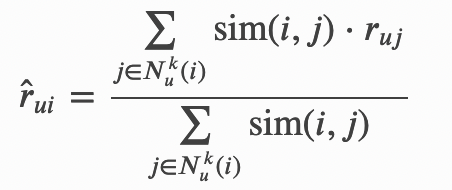

In [ ]:
## Cosine Weighted Average for ratings 
sim_options = {
    "name": ["cosine"],
    "min_support": [3,4,5,7,9],
    "user_based": [True]}

param_grid = {"sim_options": sim_options}
grid_search = grid_cf(grid_params=sim_options,algo=KNNBasic)

In [ ]:
print(grid_search.best_score["rmse"])
print(grid_search.best_params["rmse"])

1.015812210806295
{'sim_options': {'name': 'cosine', 'min_support': 3, 'user_based': True}}


### User Based -  Centered cosine similarity 
Before computing the rating we first normalize the rating for each user according to its base.
A user can be easy and tough rater and to eliminate that bias we normalize it according to his average rating.
We compute the rating by simple weighted average of rating from similar users where the weight is the cosine similarity factor .

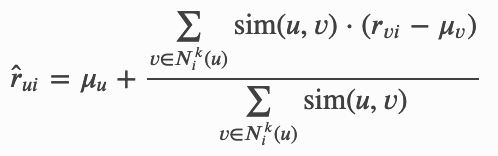

In [ ]:
## using centered KNN 
##A basic collaborative filtering algorithm, taking into account the mean ratings of each user.
sim_options = {
    "name": ["cosine"],
    "min_support": [3,4,5,7,9],
    "user_based": [True],  # Compute  similarities between items
}

param_grid = {"sim_options": sim_options}
grid_search = grid_cf(grid_params=sim_options,algo=KNNWithMeans)


In [ ]:
print(grid_search.best_score["rmse"])
print(grid_search.best_params["rmse"])

0.9450189761870179
{'sim_options': {'name': 'cosine', 'min_support': 3, 'user_based': True}}


The centered cosine has much better results since it takes the rating bias into account .



# Item Based Collaborative Filtering
Instead of finding similar users for that user we find similar items for the item . 
This works better as the rating for a given item by different users is more stable then the other way around.

In [ ]:
## Item Based 
## Without removing rating bias
sim_options = {
    "name": ["cosine"],
    "min_support": [3,4,5,7,9],
    "user_based": [False],  
}

grid_search = grid_cf(grid_params=sim_options,algo=KNNBasic)


In [ ]:
print(grid_search.best_score["rmse"])
print(grid_search.best_params["rmse"])

1.0053813908996476
{'sim_options': {'name': 'cosine', 'min_support': 3, 'user_based': False}}


In [ ]:
## Centered cosine method -removing rating bias 
sim_options = {
    "name": ["cosine"],
    "min_support": [3,4,5,7,9],
    "user_based": [False],  
}

grid_search = grid_cf(grid_params=sim_options,algo=KNNWithMeans)


In [ ]:
print(grid_search.best_score["rmse"])
print(grid_search.best_params["rmse"])

0.9615407930139712
{'sim_options': {'name': 'cosine', 'min_support': 3, 'user_based': False}}


The centered cosine has much better results since it takes the rating bias into account .


Inference User vs Item Based Collaborative Filtering := 
> User based collaborative filtering has worked better in this case then item based

> In both user and item based collaborative filtering taking rating bias into account gives better results .

# Matrix Factorization Techniques 

# Singular Value Decomposition
In singular value decomposition we split the utility matrix into 3 matrices like user-concept (U) ,movie-concept (V) and strength of concept (Sigma) .
We use RMSE And MAE to minimize the reconstruction error .

In [ ]:
svd = SVD()
cross_validate(svd,data,measures=["rmse", "mae"], cv=k_folds)

{'fit_time': (3.1808531284332275, 3.1550755500793457),
 'test_mae': array([0.70203221, 0.7052743 ]),
 'test_rmse': array([0.9091145 , 0.91397808]),
 'test_time': (0.6521835327148438, 0.6260018348693848)}

SVD has given us better results than User and Item based collaborative filtering.

# Rough

In [ ]:
## see the density and sparsity attributes
## do one two beatiful plots 
## by using aggregate maybe
## distribution of ratings 
